In [1]:
import pandas as pd
import json

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os

path = os.getcwd()
os.chdir(f"{path}")

In [2]:
db = json.load(open('./database.json'))

print(len(db))

6636


In [3]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [4]:
db[0]['nutrients'][0]

{'value': 25.18,
 'units': 'g',
 'description': 'Protein',
 'group': 'Composition'}

In [5]:
nutrients = pd.DataFrame(db[0]['nutrients'])

nutrients[:7]

,value,units,description,group
0,25.18,g,Protein,Composition
1,29.20,g,Total lipid (fat),Composition
2,3.06,g,"Carbohydrate, by difference",Composition
3,3.28,g,Ash,Other
4,376.00,kcal,Energy,Energy
5,39.28,g,Water,Composition
6,1573.00,kJ,Energy,Energy


In [6]:
info_keys = ['description', 'group', 'id', 'manufacturer']

info = pd.DataFrame(db, columns=info_keys)

info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [7]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   6636 non-null   object
 1   group         6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [8]:
# check value distribution

pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

Create metadata to analyze all nutrient information.

In [9]:
nutrients = []

for rec in db:
    fnuts = pd.DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

nutrients = pd.concat(nutrients, ignore_index=True)

In [10]:
# find duplicates

print(nutrients.duplicated().sum())

nutrients = nutrients.drop_duplicates()

14179


In [11]:
# change columns for a more concise understanding

col_mapping = {'description': 'food',
              'group': 'fgroup'}

info = info.rename(columns=col_mapping, copy=False)

info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   food          6636 non-null   object
 1   fgroup        6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [12]:
col_mapping = {'description': 'nutrient',
              'group': 'nutgroup'}

nutrients = nutrients.rename(columns=col_mapping, copy=False)

nutrients

,value,units,nutrient,nutgroup,id
0,25.180,g,Protein,Composition,1008
1,29.200,g,Total lipid (fat),Composition,1008
2,3.060,g,"Carbohydrate, by difference",Composition,1008
3,3.280,g,Ash,Other,1008
4,376.000,kcal,Energy,Energy,1008
...,...,...,...,...,...
389350,0.000,mcg,"Vitamin B-12, added",Vitamins,43546
389351,0.000,mg,Cholesterol,Other,43546
389352,0.072,g,"Fatty acids, total saturated",Other,43546
389353,0.028,g,"Fatty acids, total monounsaturated",Other,43546


In [13]:
# merge info with nutrients

ndata = pd.merge(nutrients, info, on='id', how='outer')

ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   value         375176 non-null  float64
 1   units         375176 non-null  object 
 2   nutrient      375176 non-null  object 
 3   nutgroup      375176 non-null  object 
 4   id            375176 non-null  int64  
 5   food          375176 non-null  object 
 6   fgroup        375176 non-null  object 
 7   manufacturer  293054 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [14]:
ndata.iloc[30000]

value                                             0.04
units                                                g
nutrient                                       Glycine
nutgroup                                   Amino Acids
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

<AxesSubplot:ylabel='fgroup'>

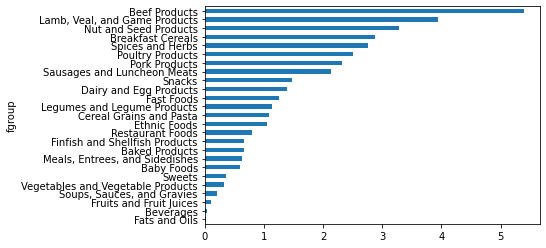

In [15]:
# median graph of Zinc proportion per food

result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)

result['Zinc, Zn'].sort_values().plot(kind='barh')

In [17]:
# find which food each nutrient is included most in

by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

get_maximum = lambda x: x.loc[x.value.idxmax()]
get_minimum = lambda x: x.loc[x.value.idxmin()]

max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

# limit to 50 kinds
max_foods.food = max_foods.food.str[:50]

In [18]:
max_foods.loc['Amino Acids']['food']

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 